In [1]:
%matplotlib inline
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re

import torch
import numpy as np

from IPython.display import display, Image

import pandas as pd

In [2]:
from output_utils import *

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
pathpattern = 'Laborieux-Arch/results/*/*/*/*/'
runs = getruns(pathpattern=pathpattern)

In [5]:
runsdf = pd.DataFrame(runs)
runsdf.sort_values('dir', ascending=False)

,model,task,pools,archi,channels,kernels,strides,paddings,fc,act,...,nbatches,figs,jit,cpu,noise,train,test,epoch,dir,call
160,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,9.99,10.00,1,./Laborieux-Arch/results/HebUnsupervised/mse/2...,../main.py --model CNN --task CIFAR10 --channe...
159,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,10.00,10.00,1,./Laborieux-Arch/results/HebUnsupervised/mse/2...,../main.py --model CNN --task CIFAR10 --channe...
158,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,9.99,10.00,1,./Laborieux-Arch/results/HebUnsupervised/mse/2...,../main.py --model CNN --task CIFAR10 --channe...
157,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,9.99,10.00,1,./Laborieux-Arch/results/HebUnsupervised/mse/2...,../main.py --model CNN --task CIFAR10 --channe...
156,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,10.00,10.00,1,./Laborieux-Arch/results/HebUnsupervised/mse/2...,../main.py --model CNN --task CIFAR10 --channe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,94.75,87.73,120,./Laborieux-Arch/results/EP/cel/2023-07-29/ori...,main.py --model CNN --task CIFAR10 --data-aug ...
3,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,92.12,87.22,81,./Laborieux-Arch/results/EP/cel/2023-07-24/09-...,main.py --model CNN --task CIFAR10 --data-aug ...
2,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],my_hard_sig,...,20,False,False,False,0.00,73.72,75.46,18,./Laborieux-Arch/results/EP/cel/2023-07-24/09-...,main.py --model CNN --task CIFAR10 --data-aug ...
1,CNN,CIFAR10,mmmm,"[784, 512, 10]","[128, 256, 512, 512]","[3, 3, 3, 3]","[1, 1, 1, 1]","[1, 1, 1, 0]",[10],mysig,...,20,False,False,False,0.00,34.60,37.08,4,./Laborieux-Arch/results/EP/cel/2023-07-18/12-...,../main.py --model CNN --task CIFAR10 --channe...


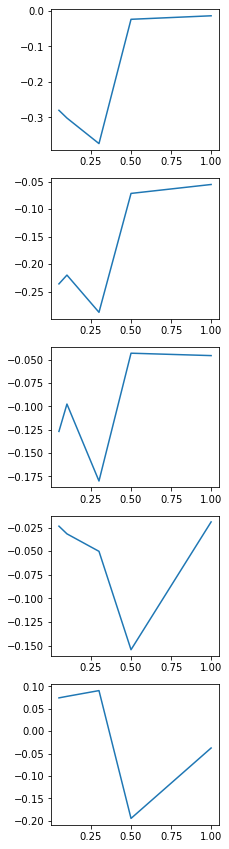

In [44]:
fig, axs = plt.subplots(5, 1, figsize=(3,15))

layerbiasmins = []
noiselevels = []

for i, (_,noisetest) in enumerate(runsdf[runsdf['noise'] > 0].iterrows()):
    model = torch.load(noisetest.dir + '/model.pt', map_location=torch.device('cpu'))
    layerbiasmins.append([])
    noiselevels.append(noisetest.noise)
    for idx in range(len(model.synapses)):
        layerbiasmins[i].append(model.synapses[idx].bias.min().data.cpu())
        # freqs, bins = torch.histogram(model.synapses[idx].bias, bins=10)
        # axs[i,idx].bar(bins[:-1].data.cpu(), freqs.data.cpu(), align='edge')
    # axs[i,0].set_ylabel('noise std: {}'.format(noisetest.noise))
    
    
for ilayer in range(5):
    axs[ilayer].plot(noiselevels, np.asarray(layerbiasmins)[:,ilayer])#, width = 0.05)

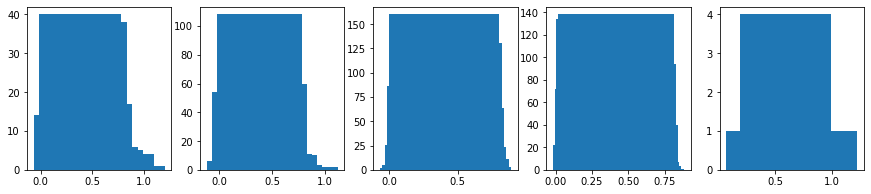

In [36]:
msemodel = torch.load(msepath + '/model.pt', map_location=torch.device('cpu'))
# msemodel = torch.load('Laborieux-Arch/results/EP/mse/2023-08-22/11-05-29_gpu0/model.pt', map_location=torch.device('cpu'))

fig, axs = plt.subplots(1, 5, figsize=(15,3))

for idx in range(len(msemodel.synapses)):
    freqs, bins = torch.histogram(msemodel.synapses[idx].bias, bins=10)
    axs[idx].bar(bins[:-1].data.cpu(), freqs.data.cpu(), align='edge')
plt.show()

In [119]:
msepath = './Laborieux-Arch/results/EP/mse/2023-08-03/orig_mse_14-38-36_gpu0_120epochs/'
# latpath = './Laborieux-Arch/results/EP/mse/2023-07-30/featip_21-04-42_gpu0_120epochs/' # lateral feature inner product inhibition
# latpath = './Laborieux-Arch/results/EP/mse/2023-08-15/17-45-32_gpu0' # trained lat all-to-all
# lat2path = './Laborieux-Arch/results/EP/cel/2023-08-15/20-15-37_gpu0' # cel version, only 2 lat layers
celpath = './Laborieux-Arch/results/EP/cel/2023-07-29/origcode_11-01-25_gpu0_120epochs/'
noise005path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-29_gpu0/'
noise01path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-32_gpu0/'
noise03path = './Laborieux-Arch/results/EP/mse/2023-08-22/11-05-35_gpu0/'

noisecel005path = './Laborieux-Arch/results/EP/cel/2023-08-22/13-40-18_gpu0'


In [120]:
mseacc = np.load(msepath + '/PGD_attack/attacked_accuracy.npy')
# latacc = np.load(latpath + '/PGD_attack/attacked_accuracy.npy')
# lat2acc = np.load(lat2path + '/PGD_attack/attacked_accuracy.npy')
celacc = np.load(celpath + '/PGD_attack/attacked_accuracy.npy')
noise005acc = np.load(noise005path + '/PGD_attack/attacked_accuracy.npy')
noise01acc = np.load(noise01path + '/PGD_attack/attacked_accuracy.npy')
noise03acc = np.load(noise03path + '/PGD_attack/attacked_accuracy.npy')

noisecel005acc = np.load(noisecel005path + '/PGD_attack/attacked_accuracy.npy')



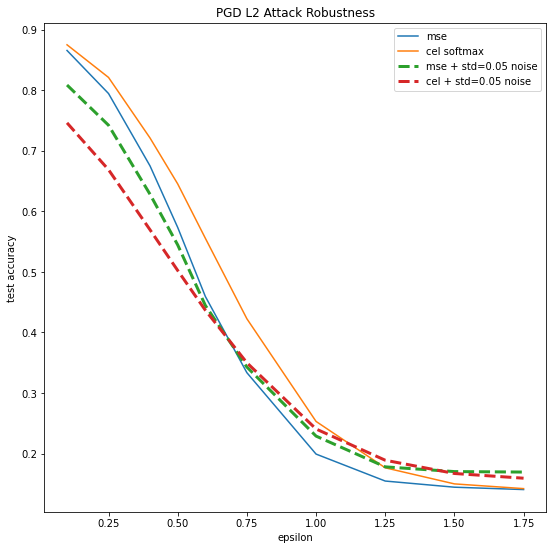

In [123]:
plt.figure(figsize=(9,9))

plt.plot(*mseacc, label='mse')
# plt.plot(*latacc, label='lateral trained (mse)')
# plt.plot(*lat2acc, label='lateral trained (cel)')
plt.plot(*celacc, label='cel softmax')
plt.plot(*noise005acc, label='mse + std=0.05 noise', linestyle='--', linewidth=3)
# plt.plot(*noise01acc, label='mse + std=0.1 noise', linestyle='--', linewidth=3)
# plt.plot(*noise03acc, label='mse + std=0.3 noise', linestyle='--', linewidth=3)
plt.plot(*noisecel005acc, label='cel + std=0.05 noise', linestyle='--', linewidth=3)

plt.title('PGD L2 Attack Robustness')
plt.xlabel('epsilon')
plt.ylabel('test accuracy')
plt.legend()

plt.savefig('PGD_Robustness_MSE_vs_CEL_vs_LatSoft.pdf', bbox_inches='tight')

In [117]:
def showattacks(attackx, x, attackpreds, origpreds, savefig=False, path='/tmp/attack.pdf'):
    fig, axs = plt.subplots(3, len(attackx), figsize=(3*len(attackx),3*3))
    axs[0,0].set_ylabel("original")
    for idx in range(len(attackx)):
        axs[0,idx].imshow(x[idx].transpose(1,2,0))#/2 + 0.5)
        axs[0,idx].set_title(str(origpreds[idx]))
        axs[0,idx].set_xticks([])
        axs[0,idx].set_yticks([])

    axs[1,0].set_ylabel("attacked")
    for idx in range(len(attackx)):
        axs[1,idx].imshow(attackx[idx].transpose(1,2,0))#/2 + 0.5)
        axs[1,idx].set_title(str(attackpreds[idx]))
        axs[1,idx].set_xticks([])
        axs[1,idx].set_yticks([])

    axs[2,0].set_ylabel("diff")
    for idx in range(len(attackx)):
        diff = attackx[idx].transpose(1,2,0) - x[idx].transpose(1,2,0)
        diff -= np.min(diff)
        diff = diff / np.max(diff)
        axs[2,idx].imshow(diff)
        axs[2,idx].set_xticks([])
        axs[2,idx].set_yticks([])

    plt.tight_layout()
    
    return fig, axs

def showexamples(path, eps, num=10):
    examples = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__examples.npy'.format(eps), allow_pickle=True)
    att_pred = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__attacked_pred.npy'.format(eps), allow_pickle=True)
    originals = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__originals.npy'.format(eps), allow_pickle=True)
    labels = np.load(path + '/PGD_attack/adversarial_examples/eps_{}/attack_15__pred_250__original_pred.npy'.format(eps), allow_pickle=True)
    
    return showattacks(examples[-1][:num], originals[-1][:num], att_pred[-1][:num], labels[-1][:num])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, 'with noise training')

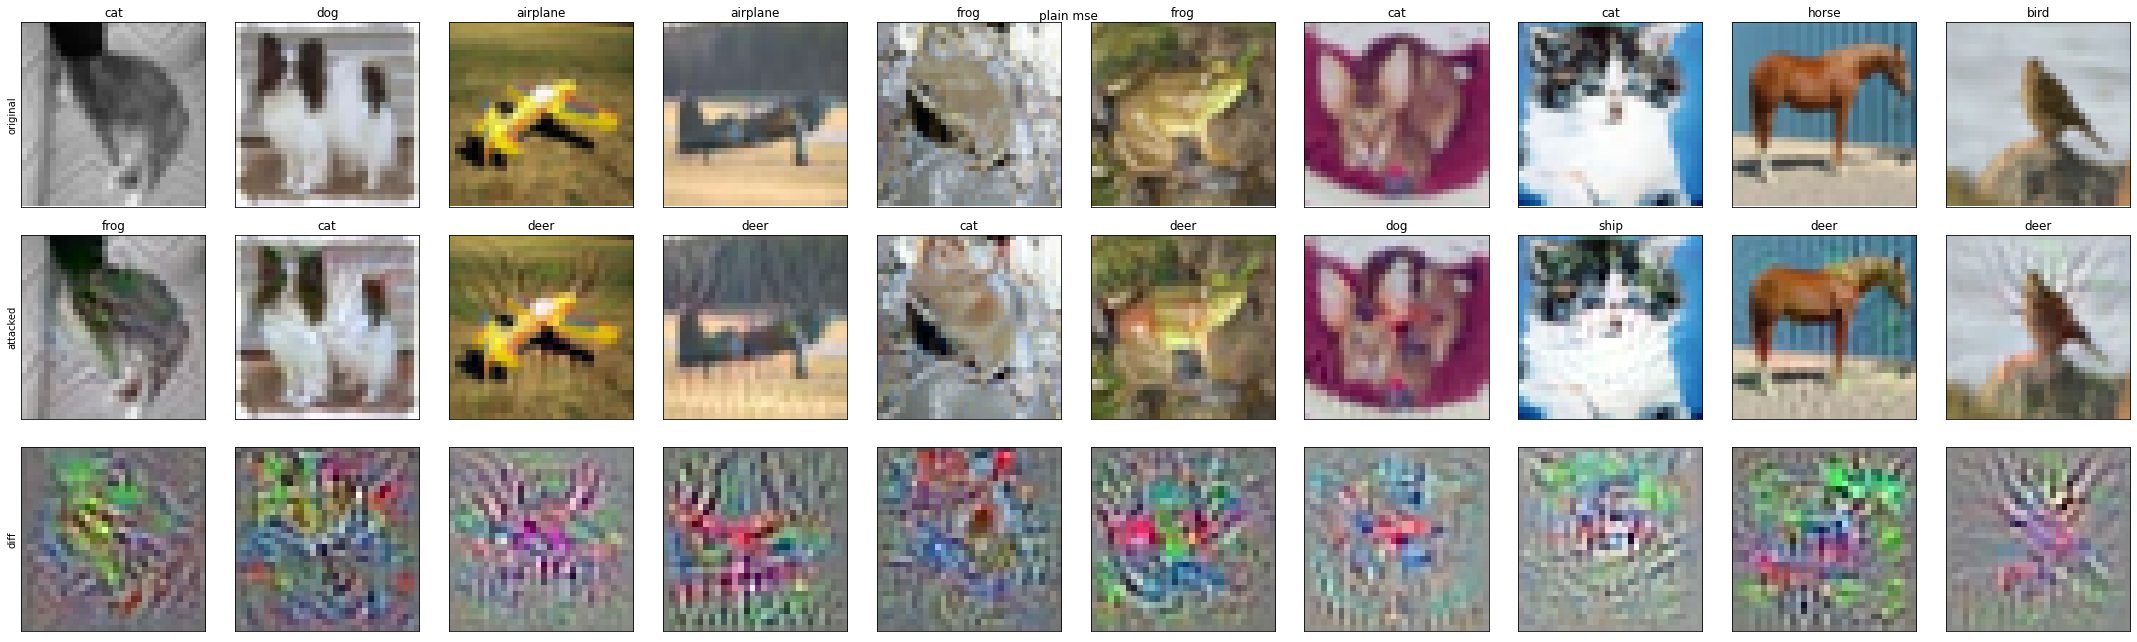

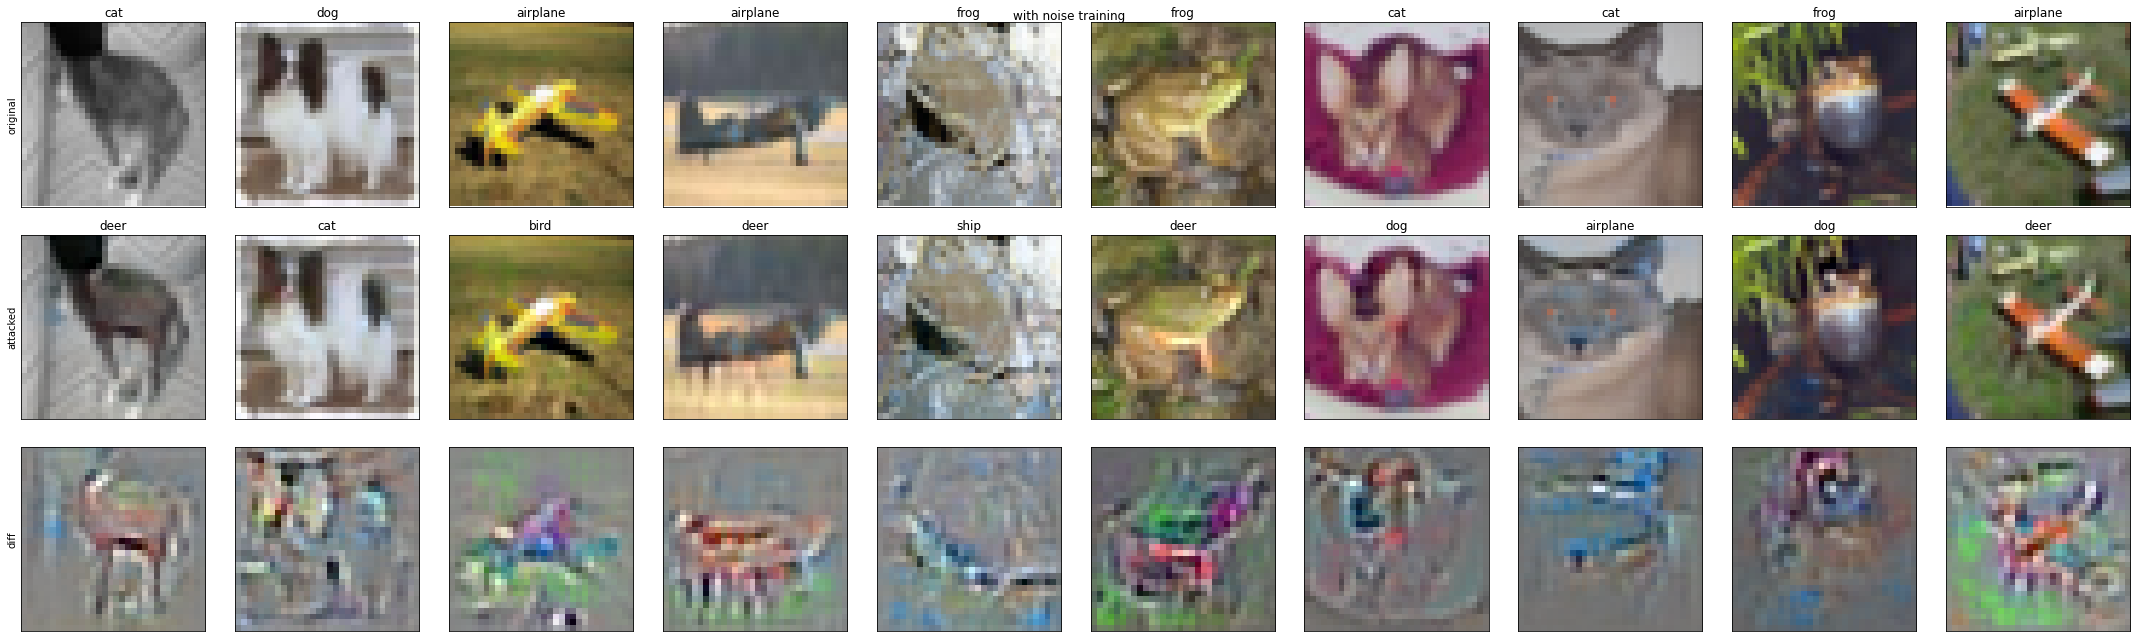

In [118]:
eps = 1.75
showexamples(msepath, eps)[0].suptitle('plain mse')
showexamples(noise03path, eps)[0].suptitle('with noise training')